1. Download the **"SPMS_descriptors.zip"** and unzip it in the same folder of this Jupyter file
2. We would get **"SPMS"** folder which contain **"cat.npy"**, **"imine.npy"** and **"thiol.npy"**
3. Tag of training is $\Delta\\Delta\$G, and it is saved in **"./Reaction_Result/ddG.npy"**
4. This Jupyter Notebook should be run on **Linux**

In [45]:
!unzip ./SPMS_descriptors.zip

Archive:  ./SPMS_descriptors.zip
  inflating: SPMS/cat.npy            
  inflating: SPMS/imine.npy          
  inflating: SPMS/thiol.npy          


## Load dependent packages

In [46]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import os,time
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor,BaggingRegressor,ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
import seaborn as sns

## Load SPMS and tag from ".npy" files

In [47]:
cat_spms = np.load('./SPMS/cat.npy')
imine_spms = np.load('./SPMS/imine.npy')
thiol_spms = np.load('./SPMS/thiol.npy')
tag = np.load('./Reaction_Result/ddG.npy')

<AxesSubplot:>

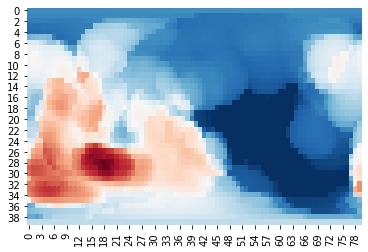

In [108]:
sns.heatmap(cat_spms[490],cbar=False,cmap='RdBu')

In [48]:
print(cat_spms.shape,imine_spms.shape,thiol_spms.shape)

(1075, 40, 80) (1075, 40, 80) (1075, 40, 80)


In [49]:
cat_spms_std = (cat_spms-cat_spms.min())/(cat_spms.max()-cat_spms.min())
imine_spms_std = (imine_spms-imine_spms.min())/(imine_spms.max()-imine_spms.min())
thiol_spms_std = (thiol_spms-thiol_spms.min())/(thiol_spms.max()-thiol_spms.min())
react_spms_std = np.concatenate([cat_spms_std.reshape(1075,40,80,1),
                                 imine_spms_std.reshape(1075,40,80,1),thiol_spms_std.reshape(1075,40,80,1)],axis=3)
tag_scale = tag.max() - tag.min()
tag_min = tag.min()
tag_std = (tag - tag_min)/tag_scale

## Train CNN

In [50]:
'''
Execute this if CUDA is available
'''
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"                           # use CPU : os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
config = tf.ConfigProto()
config.allow_soft_placement=True 
config.gpu_options.per_process_gpu_memory_fraction=0.7
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [ ]:
start_time = time.time()
total_predict_ddG = []
total_test_ddG = []
total_hist = []
for i in range(10):
    shuffle_index = list(range(0,tag_std.shape[0]))
    np.random.shuffle(shuffle_index)                                       # disturb the index
    Y_shuffled = tag_std[shuffle_index]
    X_shuffled = react_spms_std[shuffle_index]
    tag_shuffled = tag[shuffle_index]
    train_x,train_y = X_shuffled[:600],Y_shuffled[:600]
    val_x,val_y = X_shuffled[600:],Y_shuffled[600:]
    cnn_model = keras.Sequential([
                keras.layers.Conv2D(32,(11,21),activation='relu',input_shape=(40,80,3)),
                keras.layers.MaxPooling2D((2, 2)),
                keras.layers.Conv2D(32,(12,23),activation='relu'),
                keras.layers.MaxPooling2D((2, 2)),
                keras.layers.Flatten(),
                keras.layers.Dense(128, activation='relu'),
                keras.layers.Dense(128, activation='relu'),
                keras.layers.Dense(1,activation='sigmoid')
        ])
    cnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.mae
              )
    history = cnn_model.fit(train_x,train_y,validation_data=[val_x,val_y],batch_size=128,epochs=200)
    predict = cnn_model.predict(val_x)
    predict_ddG = predict*tag_scale + tag_min
    predict_ddG = predict_ddG.reshape(-1,)
    truth_ddG = tag_shuffled[600:].reshape(-1,)
    total_predict_ddG.append(predict_ddG)
    total_test_ddG.append(truth_ddG)
    total_hist.append(history)
    print('++++++++++++++++++++++')
    print('DDG R2: %f, MAE: %f'%(r2_score(predict_ddG,truth_ddG),
                                 mean_absolute_error(predict_ddG,truth_ddG)))
    print('++++++++++++++++++++++')
end_time = time.time()
time_consume = (end_time - start_time)/60
print('Time consuming: %.2f(min)'%time_consume)

## Train other models

In [52]:
react_spms_std_reshape = react_spms_std.reshape(1075,40*80*3)
react_spms_std_short = react_spms_std_reshape[:,np.where(react_spms_std_reshape.max(axis=0) != react_spms_std_reshape.min(axis=0))[0]] 

In [53]:
react_spms_std_short.shape

(1075, 7973)

In [54]:
model_names = ['KRR','SVR','DecisionTreeRegressor','ExtraTreesRegressor',
               'RandomForestRegressor','AdaBoostRegressor','BaggingRegressor']

In [55]:
max_processor_num = !cat /proc/cpuinfo| grep "processor"| wc -l
max_processor_num = eval(max_processor_num[0])

In [ ]:
num_of_cpu_core = max_processor_num         # Change this variable according to the actual conditions

start_time = time.time()
models = [KernelRidge(),SVR(),DecisionTreeRegressor(criterion='mae'),ExtraTreesRegressor(n_jobs=num_of_cpu_core,criterion='mae'),
         RandomForestRegressor(n_jobs=num_of_cpu_core,criterion='mae'),AdaBoostRegressor(),BaggingRegressor()]
shuffle_index = list(range(0,tag_std.shape[0]))
np.random.shuffle(shuffle_index)                                       # disturb the index
Y_shuffled = tag_std[shuffle_index]
X_shuffled = react_spms_std_short[shuffle_index]
tag_shuffled = tag[shuffle_index]
train_x,train_y = X_shuffled[:600],Y_shuffled[:600]
test_x,test_y = X_shuffled[600:],Y_shuffled[600:]
for tmp_model,tmp_model_name in zip(models,model_names):

    tmp_model.fit(train_x,train_y)
    predict = tmp_model.predict(test_x)
    predict_ddG = predict*tag_scale + tag_min
    predict_ddG = predict_ddG.reshape(-1,)
    truth_ddG = tag_shuffled[600:].reshape(-1,)
    print('%30s :DDG R2: %10f, MAE: %10f'%(tmp_model_name,r2_score(predict_ddG,truth_ddG),
                                 mean_absolute_error(predict_ddG,truth_ddG)))

end_time = time.time()
time_consume = (end_time - start_time)/60
print('Time consuming: %.2f(min)'%time_consume)